In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import norm
import math
import os
import sys
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
import statsmodels.api as sm
import opto_util as opto

In [2]:
plt.rcParams.update({
    'font.sans-serif': 'arial',
    'font.family': 'sans-serif'
})

In [3]:
def add_names(sheet_df):
    c_names = ['cell','area', 'mean', 'min', 'max', 'x', 'y', 'slice']
    
    if sheet_df.columns[1] == 'Unnamed: 1':
        sheet_df.columns = c_names
    return sheet_df

def measure_z_stack(stack_df):
    count = np.shape(stack_df)[0]
    
    min_x = np.min(stack_df.x)
    max_x = np.max(stack_df.x)
    min_y = np.min(stack_df.y)
    max_y = np.max(stack_df.y)
    min_z = np.min(stack_df.slice)
    max_z = np.max(stack_df.slice)
    volume = (max_x-min_x)/1000*(max_y-min_y)/1000*(max_z-min_z)/1000
    volume = max_x/1000*max_y/1000*max_z/1000
    density = count/volume
    summary_dict = {'min_x':min_x,'max_x':max_x,'min_y':min_y,'max_y':max_y,'min_z':min_z,'max_z':max_z,
                   'volume':volume,'count':count,'density':density}
    return summary_dict

def Cre_df_from_xls(xls_file):
    xls = pd.ExcelFile(xls_file)
    dict_list=[]
    for sheet_name in xls.sheet_names:
    
        sheet_df = xls.parse(sheet_name)
        sheet_df = add_names(sheet_df)
        dic=measure_z_stack(sheet_df)
        dic['sheet_name']=sheet_name
        dict_list.append(dic)
    return pd.DataFrame(dict_list)

In [4]:
PenkKv_df = Cre_df_from_xls('cell_locations/penk_kv_z_stacks.xlsx')
RorbKv_df = Cre_df_from_xls('cell_locations/rorb_kv_z_stacks.xlsx')
RorbAi_df = Cre_df_from_xls('cell_locations/rorb_ai167_z_stacks.xlsx')
Tlx3Kv_df = Cre_df_from_xls('cell_locations/tlx3_kv_z_stacks.xlsx')
Ntsr1Ai_df = Cre_df_from_xls('cell_locations/ntsr1_ai167_z_stacks.xlsx')
PvalbKv_df = Cre_df_from_xls('cell_locations/pvalb_kv_z_stacks.xlsx')
SstAi_df = Cre_df_from_xls('cell_locations/sst_ai167_z_stacks.xlsx')
SstKv_df = Cre_df_from_xls('cell_locations/sst_kv_z_stacks.xlsx')
Scnn1a_df = Cre_df_from_xls('cell_locations/scnn1a_ai167_z_stacks.xlsx')


In [5]:
PenkKv_df

,min_x,max_x,min_y,max_y,min_z,max_z,volume,count,density,sheet_name
0,7.583,285.222,7.583,288.139,11.0,140.0,0.011506,115,9995.044665,03232020_049
1,6.416,288.139,16.915,290.472,15.0,121.0,0.010127,49,4838.429196,05282020_113
2,2.333,281.139,22.748,271.807,1.0,132.0,0.010087,90,8922.505931,03232020_050
3,3.500,289.305,106.740,285.222,1.0,72.0,0.005941,60,10099.033052,05282020_134
4,3.500,273.557,65.910,288.139,1.0,56.0,0.004414,39,8835.409912,05282020_137
5,4.083,274.723,5.833,294.555,1.0,112.0,0.009063,93,10261.326498,05282020_138
6,7.583,296.888,16.915,286.389,1.0,94.0,0.007992,86,10760.231637,05282020_144
7,4.666,296.304,31.497,289.305,7.0,72.0,0.006172,52,8425.145181,05282020_145
8,7.583,293.388,6.999,242.060,1.0,87.0,0.006179,67,10844.016620,05282020_146
9,1.750,282.306,2.333,275.890,1.0,83.0,0.006464,76,11756.537465,05282020_161


In [6]:
def measure_density_tdT(cell_locs,thickness, res):
    min_x=np.min(cell_locs.x)
    max_x=np.max(cell_locs.x)
    min_y=np.min(cell_locs.y)
    max_y=np.max(cell_locs.y)
    dx=max_x-min_x
    dy=max_y-min_y
    dx_m=dx/1000.*res
    dy_m=dy/1000.*res
    thickness/=1000.
    sa=dx_m*dy_m
    v=dx_m*dy_m*thickness
    count=np.shape(cell_locs)[0]
    density=count/v
    summary_dict = {'min_x':min_x,'max_x':max_x,'min_y':min_y,'max_y':max_y,'thickness':thickness,
                    'volume':v,'count':count,'density':density,'sa':sa}
    return summary_dict

In [7]:
transgenic_tdT_xls=pd.ExcelFile('cell_locations/transgenic_characterization_links.xlsx')
tdT_key=transgenic_tdT_xls.parse('image_info',dtype={'image_id': str})

dict_list=[]
for i in tdT_key.index:
    image_id = tdT_key['image_id'][i]
    cell_locs=transgenic_tdT_xls.parse(str(image_id))
    thickness=tdT_key['thickness'][i]
    
    res=tdT_key['resolution'][i]
    cre=tdT_key['Cre'][i]
    summary_dict=measure_density_tdT(cell_locs,thickness,res)
    summary_dict['Cre']=cre
    dict_list.append(summary_dict)
tdT_dens=pd.DataFrame(dict_list)
tdT_dens

,min_x,max_x,min_y,max_y,thickness,volume,count,density,sa,Cre
0,7781.000,9145.000,699.333,1568.667,0.025,0.029538,175,5924.638730,1.181507,Sst
1,7598.667,9822.333,893.333,1845.333,0.025,0.052733,287,5442.522747,2.109316,Sst
2,7574.000,9339.333,552.000,1493.333,0.025,0.041395,131,3164.653985,1.655789,Sst
3,7745.000,8794.000,2562.000,2805.000,0.033,0.008382,126,15032.794214,0.253990,Penk
4,4820.000,5734.667,2537.333,2716.000,0.033,0.005373,76,14143.508817,0.162833,Penk
5,4802.000,5892.000,2230.000,2410.000,0.033,0.006451,80,12400.577560,0.195494,Penk
6,6791.000,7717.000,2777.000,3121.000,0.033,0.010474,205,19572.006930,0.317398,Rorb
7,3575.333,4515.333,399.667,737.000,0.033,0.010426,213,20428.846738,0.315953,Rorb
8,6957.000,8179.000,1493.667,1844.333,0.033,0.014090,227,16110.607640,0.426973,Rorb
9,5555.000,6145.000,1318.000,1673.000,0.033,0.006887,165,23958.217794,0.208697,Tlx3


In [8]:
print (np.mean(tdT_dens[tdT_dens.Cre=='Sst'].density))
print (np.mean(tdT_dens[tdT_dens.Cre=='Pvalb'].density))

4843.938487417326
4594.787556620368


Penk
9255.70289868112 cells/mm3
Rorb
19813.14510734547 cells/mm3
Tlx3
22330.49893935085 cells/mm3
Sst
4095.64525514143 cells/mm3
Pvalb
3349.1725035755426 cells/mm3


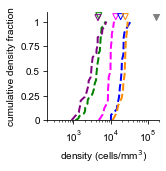

In [11]:

fs=10
tick_size=4
df_list=[PenkKv_df,RorbKv_df,Tlx3Kv_df, SstKv_df, PvalbKv_df]
colors=['magenta', 'blue', 'darkorange', 'green', 'purple']
styles=['dashed', 'dashed', 'dashed','dashed', 'dashed']
cres=['Penk','Rorb','Tlx3','Sst','Pvalb']
offs=[0,0,0,0.01,-0.01] ##offsets for marker plotting to avoid Pvalb/Sst overlap
fig, ax = plt.subplots()
norm_ys=[]
tdT_dens_list=[]
opto_dens_list=[]
csv_file=open('mapping_densities.csv','w')
for i in range(len(df_list)):
    df=df_list[i]
    y=df.density
    y_sorted= np.sort(y)
    cdf=np.linspace(0.,1.,np.size(y_sorted))
    color=colors[i]
    style=styles[i]
    cre=cres[i]
    off=offs[i]
    ax.plot(y_sorted,cdf,c=color, ls=style, lw=2)
    tdT_df=tdT_dens[tdT_dens.Cre==cre]
    tdT_mean=np.mean(tdT_df.density)
    tdT_dens_list.append(tdT_mean)
    tdT_std=np.std(tdT_df.density)
    description=cre+':AAV density (cells/mm^3)'
    opto.write_csv(csv_file,y_sorted,description)
    ax.scatter([tdT_mean],[1.05+off],edgecolor=color,facecolor='none',marker='v')
    norm_y=y/tdT_mean
    print(cre)
    print(np.mean(y), 'cells/mm3')
    opto_dens_list.append(np.mean(y))
    norm_ys.extend(norm_y)
ax.scatter([164000],[1.05],c='grey',marker='v')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xscale('log')
plt.axis([200,200000,0,1.1])
plt.ylabel('cumulative density fraction')
plt.xlabel('density (cells/mm$^{3}$)')
fig.set_figheight(2)
fig.set_figwidth(2)    
#plt.savefig('AAV_densities.svg')

In [12]:
opto.write_csv(csv_file,cres,'Cre:AAV')
opto.write_csv(csv_file,tdT_dens_list,'Cre_tdT_density')
opto.write_csv(csv_file,opto_dens_list,'AAV_tdT_density')

In [13]:
print(np.mean(norm_ys))

0.8350665951015351


Rorb
4424.813404671313 cells/mm3
Scnn1a
1730.0018522123257 cells/mm3
Ntsr1
10094.000592162387 cells/mm3
Sst
1429.936587938761 cells/mm3


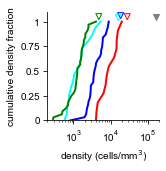

In [14]:

fs=10
tick_size=4
df_list=[RorbAi_df, Scnn1a_df,Ntsr1Ai_df,SstAi_df]
colors=['blue','cyan','red','green']
styles=['solid','solid','solid','solid']
cres=['Rorb','Scnn1a','Ntsr1','Sst']
offs=[0.01,-0.01,0,0]
fig, ax = plt.subplots()
norm_ys=[]
tdT_dens_list=[]
opto_dens_list=[]
for i in range(len(df_list)):
    df=df_list[i]
    y=df.density
    y_sorted= np.sort(y)
    cdf=np.linspace(0.,1.,np.size(y_sorted))
    color=colors[i]
    style=styles[i]
    cre=cres[i]
    off=offs[i]
    ax.plot(y_sorted,cdf,c=color, ls=style, lw=2)
    tdT_df=tdT_dens[tdT_dens.Cre==cre]
    tdT_mean=np.mean(tdT_df.density)
    tdT_dens_list.append(tdT_mean)
    tdT_std=np.std(tdT_df.density)
    description=cre+':Ai167 density (cells/mm^3)'
    opto_dens_list.append(np.mean(y))
    opto.write_csv(csv_file,y_sorted,description)
    ax.scatter([tdT_mean],[1.05+off],edgecolor=color,facecolor='none',marker='v')
    norm_y=y/tdT_mean
    print(cre)
    print(np.mean(y), 'cells/mm3')
    norm_ys.extend(norm_y)
    

ax.scatter([164000],[1.05],c='grey',marker='v')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xscale('log')
plt.axis([200,200000,0,1.1])
plt.ylabel('cumulative density fraction')
plt.xlabel('density (cells/mm$^{3}$)')
fig.set_figheight(2)
fig.set_figwidth(2)    
#plt.savefig('Ai167_densities.svg')

In [15]:
opto.write_csv(csv_file,cres,'Cre:Ai167')
opto.write_csv(csv_file,tdT_dens_list,'Cre_tdT_density')
opto.write_csv(csv_file,opto_dens_list,'Ai167_tdT_density')

In [16]:
csv_file.close()

In [17]:
print(np.mean(norm_ys))

0.2506456563546914


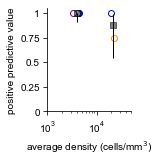

In [18]:
conf_list=[RorbKv_df,Tlx3Kv_df, RorbAi_df, SstKv_df, PvalbKv_df]
tested=[4.,4.,4.,15.,7.]
conf=[4.,3.,4.,15.,7.]
colors=['blue','darkorange','blue','green','purple']
facecolors=['white','white','blue','white','white']
dens_l=[]
i=0
fig, ax = plt.subplots()
for df in conf_list:
    dens=[np.mean(df.density)]
    c=colors[i]
    fc=facecolors[i]
    ppr=conf[i]/tested[i]
    ax.scatter(dens,ppr,ec=c,fc=fc)
    dens_l.append(dens)
    i+=1
dens_dens=np.mean(dens_l[0:2])
dens_sparse=np.mean(dens_l[2:])
ax.scatter([dens_dens],[7./8],c='black',alpha=0.5,marker='s')
CI=sm.stats.proportion_confint([7],[8], method='jeffreys')
ax.fill_between([dens_dens],CI[0],CI[1],color='black')
ax.scatter([dens_sparse],[26/26.],c='black',alpha=0.5,marker='s')
CI=sm.stats.proportion_confint([26],[26], method='jeffreys')
ax.fill_between([dens_sparse],CI[0],CI[1],color='black')
ax.yaxis.set_label('positive predictive value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.set_ylim([0,1.05])
xl=ax.get_xlim()
ax.set_xlim([1000,50000])
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.ylabel('positive predictive value')
fig.set_figheight(1.9)
fig.set_figwidth(1.5)
plt.xlabel('average density (cells/mm$^{3}$)')
plt.xscale('log')
#plt.savefig('ppv_density.svg')
plt.show()

In [19]:
##results of Gaussian fits to measured spatial resolutions for precise firing (Figure 1-supp. 2E, Figure 1-suppl. 3D)
RorbKv_popt_x=[1.        , 0.84361004, 6.77530826]
PenkKv_popt_x=[ 1.        , -0.2978597 ,  5.44462275]
Tlx3Kv_popt_x=[1.        , 0.1008984 , 5.33277538]
SstKv_popt_x=[0.99999957, 0.05276496, 5.04222882]
PvalbKv_popt_x=[ 1.        , -1.        ,  9.57963163]
SstAi_popt_x=[1.        , 0.35355629, 6.09053678]
RorbAi_popt_x=[ 1.        , -0.61669749,  6.64957942]
Ntsr1Ai_popt_x=[ 1.        ,  1.        , 10.06377989]
Scnn1aAi_popt_x=[0.99000003, 1.        , 6.47350589]

RorbKv_popt_z=[ 1.        ,  1.        , 27.63557715]
PenkKv_popt_z=[ 1.        , -1.        , 21.11038258]
Tlx3Kv_popt_z=[ 1.        ,  0.66846301, 15.1767489 ]
RorbAi_popt_z=[ 1.        ,  1.        , 24.72929232]
SstKv_popt_z=[ 1.        , -0.67435284, 15.5338903 ]
PvalbKv_popt_z=[ 1.        , -1.        , 23.22440667]
SstAi_popt_z=[ 1.        , -0.29772707, 22.76692667]
Scnn1aAi_popt_z=[ 1.        , -1.        , 20.55288537]
Ntsr1Ai_popt_z=[ 1.        ,  1.        , 28.37021021]

SstAi_sens=15./17.
SstKv_sens=15./16.
RorbAi_sens=17./19.
RorbKv_sens=10./10.
Tlx3Kv_sens=11./12.
Scnn1a_sens=13./15.
PenkKv_sens=8./8.
PvalbKv_sens=12./14.
Ntsr1_sens=10./10.

In [20]:
def make_inter_df(xls_path, popt_x, popt_z):
    xls = pd.ExcelFile(xls_path)
    df_list=[]
    for sheet_name in xls.sheet_names:
        sheet_df = xls.parse(sheet_name)
        sheet_df = add_names(sheet_df)
        sheet_df = add_inter_df2(sheet_df, sheet_name, popt_x, popt_z)
        df_list.append(sheet_df)
    inter_df = pd.DataFrame()
    inter_df = inter_df.append(df_list).reset_index()
    return inter_df

def add_inter_df2(stack_df,sheet_name, popt_x, popt_z):
    xyz_array=np.array(stack_df[['x','y','slice']])
    dx=[]
    dy=[]
    dz=[]
    dxy=[]
    neigh_probs=[]
    tot_prob=[]
    max_prob=[]
    for i in range(np.shape(xyz_array)[0]):  ##for each cell
        cell_i_coact=[] ##a list with Pcoactivation for all j
        neigh_dict = neighbors2(xyz_array,i, popt_x, popt_z)
        dx.append(neigh_dict['neigh_dx'])
        dy.append(neigh_dict['neigh_dy'])
        dz.append(neigh_dict['neigh_dz'])
        dxy.append(neigh_dict['neigh_dxy'])
        neigh_probs.append(neigh_dict['neigh_probs'])
        tot_prob.append(np.sum(neigh_dict['neigh_probs']))
        max_prob.append(np.max(neigh_dict['neigh_probs']))
    stack_df['dx']=dx
    stack_df['dy']=dy
    stack_df['dz']=dz
    stack_df['dxy']=dxy
    stack_df['neigh_probs']=neigh_probs
    stack_df['tot_prob']=tot_prob
    stack_df['max_prob']=max_prob
    stack_df['min_x']= np.min(stack_df.x)
    stack_df['max_x'] = np.max(stack_df.x)
    stack_df['min_y'] = np.min(stack_df.y)
    stack_df['max_y'] = np.max(stack_df.y)
    stack_df['min_z'] = np.min(stack_df.slice)
    stack_df['max_z'] = np.max(stack_df.slice)
    stack_df['sheet_name'] = sheet_name
    return stack_df 

def neighbors2(xyz_array,i,popt_x, popt_z):
    neigh_dx = []
    neigh_dy = []
    neigh_dz = []
    neigh_dxy = []
    neigh_probs = []
    for j in range(np.shape(xyz_array)[0]):
        if i!=j:
            dx = xyz_array[j,0] - xyz_array[i,0]
            dy = xyz_array[j,1] - xyz_array[i,1]
            dz = xyz_array[j,2] - xyz_array[i,2]
            dxy = math.sqrt(dx**2+dy**2)
            prob = off_activation_prob2(dxy,dz, popt_x, popt_z)
            neigh_dx.append(dx)
            neigh_dy.append(dy)
            neigh_dz.append(dz)
            neigh_dxy.append(dxy)
            neigh_probs.append(float(prob))
    return {'neigh_dx':neigh_dx, 'neigh_dy':neigh_dy,'neigh_dz':neigh_dz,'neigh_dxy':neigh_dxy,
           'neigh_probs':neigh_probs}


def off_activation_prob2(dxy,dz, popt_x, popt_z):
    max_xy=40
    max_z=100
    if dxy > max_xy or abs(dz) > max_z: #save some time if large distance between neighbors
        return 0
    else:
        xy_prob = Gauss(dxy, *popt_x)
        z_prob = Gauss(dz, *popt_z)
        return min([xy_prob,z_prob])
    
    
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

In [21]:
PenkKv_inter=make_inter_df('cell_locations/penk_kv_z_stacks.xlsx',PenkKv_popt_x, PenkKv_popt_z)
RorbKv_inter=make_inter_df('cell_locations/rorb_kv_z_stacks.xlsx',RorbKv_popt_x, RorbKv_popt_z)
RorbAi_inter=make_inter_df('cell_locations/rorb_ai167_z_stacks.xlsx',RorbAi_popt_x, RorbAi_popt_z)
Tlx3Kv_inter=make_inter_df('cell_locations/tlx3_kv_z_stacks.xlsx',Tlx3Kv_popt_x, Tlx3Kv_popt_z)
Scnn1a_inter=make_inter_df('cell_locations/scnn1a_ai167_z_stacks.xlsx',Scnn1aAi_popt_x, Scnn1aAi_popt_z)
Ntsr1_inter=make_inter_df('cell_locations/ntsr1_ai167_z_stacks.xlsx',Ntsr1Ai_popt_x, Ntsr1Ai_popt_z)
PvalbKv_inter=make_inter_df('cell_locations/pvalb_kv_z_stacks.xlsx',PvalbKv_popt_x, PvalbKv_popt_z)
SstKv_inter=make_inter_df('cell_locations/sst_kv_z_stacks.xlsx',SstKv_popt_x, SstKv_popt_z)
SstAi_inter=make_inter_df('cell_locations/sst_ai167_z_stacks.xlsx',SstAi_popt_x, SstAi_popt_z)

In [66]:
##created data frames where each row is cell. dxy, dz each contain an array for each cell with corresponding 
##distances to all imaged neighbors, neigh_probs contains an array with corresponding off-target estimates
c_list=['index','x','y','slice','dz','dxy','neigh_probs','tot_prob','max_prob','sheet_name']
PenkKv_inter[c_list]

,index,x,y,slice,dz,dxy,neigh_probs,tot_prob,max_prob,sheet_name
0,0,160.984,65.910,11.0,"[2.0, 2.0, 8.0, 9.0, 11.0, 12.0, 15.0, 19.0, 2...","[121.93987076014146, 155.0081277385157, 96.875...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.149611e-10,5.149611e-10,03232020_049
1,1,158.068,187.815,13.0,"[-2.0, 0.0, 6.0, 7.0, 9.0, 10.0, 13.0, 17.0, 1...","[121.93987076014146, 99.2958340012309, 134.047...","[0.0, 0.0, 0.0, 0.0, 0.0, 8.037601760233238e-1...",1.004836e-02,4.411090e-03,03232020_049
2,2,58.911,182.566,13.0,"[-2.0, 0.0, 6.0, 7.0, 9.0, 10.0, 13.0, 17.0, 1...","[155.0081277385157, 99.2958340012309, 214.0390...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.176097e-01,1.031087e-01,03232020_049
3,3,253.725,93.908,19.0,"[-8.0, -6.0, -6.0, 1.0, 3.0, 4.0, 7.0, 11.0, 1...","[96.87507979351551, 134.04770157671484, 214.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.437228e-05,1.070152e-05,03232020_049
4,4,218.729,140.570,20.0,"[-9.0, -7.0, -7.0, -1.0, 2.0, 3.0, 6.0, 10.0, ...","[94.38538353474016, 76.88853585548368, 165.243...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4566259959916...",2.134046e-03,1.818031e-03,03232020_049
...,...,...,...,...,...,...,...,...,...,...
1244,107,131.820,173.233,149.0,"[-148.0, -148.0, -148.0, -144.0, -138.0, -138....","[73.1983070979104, 87.89089839681921, 154.7471...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.043849e-01,1.031087e-01,05272020_053
1245,108,192.481,181.399,149.0,"[-148.0, -148.0, -148.0, -144.0, -138.0, -138....","[48.95661598803578, 113.97923453857723, 200.87...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.926322e-02,3.002056e-02,05272020_053
1246,109,197.731,164.484,149.0,"[-148.0, -148.0, -148.0, -144.0, -138.0, -138....","[66.6593153580203, 129.52953177171602, 213.668...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.020853e-02,4.210182e-03,05272020_053
1247,110,47.245,134.154,149.0,"[-148.0, -148.0, -148.0, -144.0, -138.0, -138....","[162.66277790570282, 137.73187226274098, 143.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.316992e-04,1.316746e-04,05272020_053


In [49]:
def plot_neighbors(sheet_df, i,ax):
    dxys=sheet_df.dxy[i]
    dzs = sheet_df.dz[i]
    probs = sheet_df.neigh_probs[i]
    ax.scatter(dxys,dzs,c=probs)

def plot_neighbors_3d(sheet_df, i,ax,sens_factor=1):
    
    dxs=np.array(sheet_df.dx.values[i])
    dys = np.array(sheet_df.dy.values[i])
    dzs = np.array(sheet_df.dz.values[i])
    probs = np.array(sheet_df.neigh_probs.values[i])*sens_factor
    neigh_df=pd.DataFrame({'x':dxs,'y':dys,'z':dzs,'prob':probs})
    z_p=neigh_df[neigh_df.prob<0.010]
    z_p=z_p[(abs(z_p.x)<50) & (abs(z_p.y)<50)]
    plot_df=neigh_df[neigh_df.prob>0.01]
    count=np.shape(plot_df)[0]
    ax.scatter(plot_df.x,plot_df.y,plot_df.z,c=plot_df.prob,cmap='plasma',alpha=0.5,vmin=0,vmax=1,s=7,zorder=1)
    ax.scatter(z_p.x,z_p.y,z_p.z,c='black',alpha=0.1,s=1,zorder=0)
    return count

def overlay_cells(df,n,sens_factor=1,name=''):
    df['z_dist']=df['max_z']-df['slice']

    sub=df[(df.z_dist>30) & (df.slice>30)] #subset for cells >30 microns from borders
    random.seed(10)
    random_list=random.sample(list(sub.index),n)
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111, projection='3d')
    count=0
    for i in random_list:
        i_count=plot_neighbors_3d(df,i,ax,sens_factor)
        count=count+i_count
    print(count)
    xyzlim = np.array([ax.get_xlim3d(),ax.get_ylim3d(),ax.get_zlim3d()]).T
    XYZlim = [min(xyzlim[0]),max(xyzlim[1])]
    XYZlim = [-50,50]
    ax.set_xlim3d(XYZlim)
    ax.set_ylim3d(XYZlim)
    ax.set_zlim3d(XYZlim)
    ax.set_box_aspect(aspect = (1,1,1))
    ax.scatter([0],[0],[0],s=12,c='green',zorder=2)
    ax.set_xlabel('x (' r'$\mu$'+'m)',labelpad=0)
    ax.set_ylabel('y (' r'$\mu$'+'m)',labelpad=0)
    ax.set_zlabel('z (' r'$\mu$'+'m)',labelpad=0)
    tvs=[-50,-25,0,25,50]    
    ax.set(xticks=tvs, yticks=tvs,zticks=tvs)
    ax.axes.xaxis.set_ticklabels(['-50','','0','','50'])
    ax.axes.yaxis.set_ticklabels([-50,'',0,'',50])
    ax.axes.zaxis.set_ticklabels([-50,'',0,'',50])
    ax.tick_params(axis='x', which='major', pad=0)
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='z', which='major', pad=0)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
        item.set_fontsize(8)
    fig.tight_layout()
    if len(name)>0:
        plt.savefig(name+'3d.svg')
    plt.show()


93


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


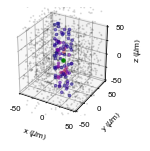

In [50]:
overlay_cells(PenkKv_inter,100,PenkKv_sens,'Penk_')

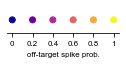

In [51]:
fig,ax=plt.subplots()
p=ax.scatter([0,0.2,0.4,0.6,0.8,1],[1,1,1,1,1,1],c=[0,0.2,0.4,0.6,0.8,1],alpha=1,cmap='plasma')



plt.yticks([])
plt.xticks([0,0.2,0.4,0.6,0.8,1],fontname='arial')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_xlabel('off-target spike prob.',fontsize=8,fontname='arial')
fig.set_figheight(0.5)
fig.set_figwidth(2)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(axis='both', which='major', labelsize=8)
#plt.savefig('cbar_h.svg')

526


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


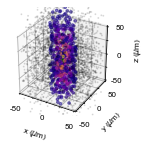

In [52]:
overlay_cells(RorbKv_inter,100,sens_factor=RorbKv_sens)


35


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


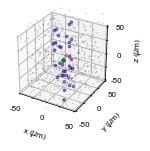

In [53]:
overlay_cells(RorbAi_inter,100,sens_factor=RorbAi_sens)

161


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


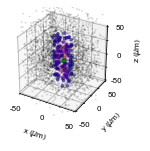

In [56]:
overlay_cells(Tlx3Kv_inter,100,Tlx3Kv_sens,'Tlx3_')


22


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


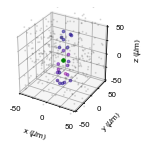

In [57]:
overlay_cells(SstKv_inter,100,SstKv_sens,'SstKv_')

359


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


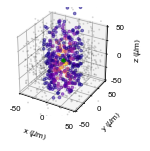

In [58]:
overlay_cells(Ntsr1_inter,100,Ntsr1_sens)

95


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


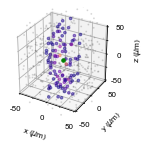

In [59]:
overlay_cells(PvalbKv_inter,100,PvalbKv_sens)

3


/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2526501001.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


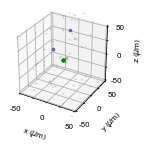

In [60]:
overlay_cells(SstAi_inter,100,SstAi_sens)

In [67]:
def midPoints(x):
    x=np.array(x)
    x_values=(x[:-1]+x[1:])/2
    return x_values

def neighbors_tested(df,z_bins=np.arange(-75,76,10),xy_bins=[0,10,20,30,40,50,60],savename='',vmax=0.4):
    n_bins=len(z_bins)-1
    n_bins_xy=len(xy_bins)-1
    z_summary=midPoints(z_bins)
    summary_tested=[]
    summary_neighs=np.zeros(shape=(n_bins_xy,n_bins))
    for i in df.index:
        cell=df.loc[i]
        probed_down=cell.max_z>=z_summary+cell.slice
        probed_up=1<=z_summary+cell.slice
        summary_tested.append(probed_down*probed_up)
        H_cell, xedges, yedges = np.histogram2d(cell.dxy,cell.dz, bins=(xy_bins, z_bins))
        summary_neighs+=H_cell
    summary_tested=np.array(summary_tested)
    counts=np.sum(summary_tested,axis=0)
    out=np.tile(counts,(n_bins_xy,1))
    neighbors_heatmap(summary_neighs,xedges,yedges,savename)
    corrected_heatmap(summary_neighs,out,xedges,yedges,savename,vmax=vmax)
    return {'neighbors':summary_neighs,'tested':out, 'xedges':xedges,'yedges':yedges}

def neighbors_heatmap(neighbors, xedges, yedges,savename=''):
    fig, ax = plt.subplots()
    p=ax.imshow(neighbors.T, interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0,cmap='gray')
    cb=plt.colorbar(p,fraction=0.046*2.2, pad=0.04)
    cb.ax.tick_params(labelsize=8) 
    cb.set_label('# neighbors', fontsize=8, fontname='arial')
    plt.ylabel('axial offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
    plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
    fig.set_figwidth(0.8)
    plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
    plt.yticks(fontname = "arial")
    plt.xticks(fontname= "arial")
    if len(savename)>0:
        plt.savefig(savename+'_neighsHeat.svg')
    plt.show()
    
def corrected_heatmap(neighbors, tested, xedges, yedges,savename='',vmax=0.4):
    fig, ax = plt.subplots()
    p=ax.imshow(neighbors.T/tested.T, interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0,vmax=vmax,cmap='YlGn_r')
    cb=plt.colorbar(p, fraction=0.046*2.2, pad=0.04)
    cb.set_label('neighbors per cell', fontsize=8, fontname='arial')
    cb.ax.tick_params(labelsize=8) 
    plt.ylabel('axial offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
    plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
    fig.set_figwidth(0.8)
    plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
    plt.yticks(fontname = "arial")
    plt.xticks(fontname= "arial")
    if len(savename)>0:
        plt.savefig(savename+'_psCorr.svg')
    plt.show()
    
def photostim_heatmap_fit(xy_popt,z_popt,xy_d,z_d):
    midx=(xy_d[:-1]+xy_d[1:])/2
    midz=(z_d[:-1]+z_d[1:])/2
    summary_probs=np.zeros(shape=[len(midx),len(midz)])
    i=0
    for x in midx:
        j=0
        x_p = Gauss(x, *xy_popt)
        for z in midz:
            z_p = Gauss(z, *z_popt)
            if z_p<x_p:
                act_prob = z_p
            else:
                act_prob = x_p
            act_prob=x_p*z_p
            act_prob=np.min([x_p,z_p])
            summary_probs[i,j]=act_prob
            j+=1
        i+=1
    return summary_probs

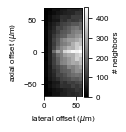

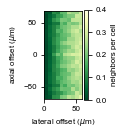

In [82]:
##grey scale heatmap is a 2d hist of the number of neighbors. We find more neighbors within an imaging plane due to
##edge effects. This is also observed if objects are randomly placed in a confined space.
##green-yellow heatmap normalizes the previous heatmap by the number of cells a sufficient distance from the z-borders
##of the imaging volume
x_d=np.arange(0,61,6)
z_d=np.arange(-69,70,6)

Tlx3_neighbors=neighbors_tested(Tlx3Kv_inter,z_bins=z_d,xy_bins=x_d)

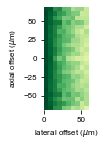

In [83]:
##cleaned version for fig
neighbors=Tlx3_neighbors['neighbors']
tested=Tlx3_neighbors['tested']
xedges=Tlx3_neighbors['xedges']
yedges=Tlx3_neighbors['yedges']
fig, ax = plt.subplots()
p = ax.imshow(neighbors.T/tested.T, interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0,vmax=0.4,cmap='YlGn_r')
fig.set_figwidth(0.8)
plt.ylabel('axial offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.yticks(fontname = "arial")
plt.xticks(fontname= "arial")
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#plt.savefig('Tlx3Kv_normNeigh.svg')

In [84]:
np.savetxt("Tlx3_neighs.csv", neighbors.T/tested.T, delimiter=",")

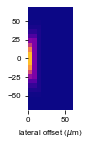

In [85]:
Tlx3Kv_ps_array = photostim_heatmap_fit(Tlx3Kv_popt_x,Tlx3Kv_popt_z,x_d,z_d)
Tlx3Kv_ps_array = Tlx3Kv_ps_array
xedges=Tlx3_neighbors['xedges']
yedges=Tlx3_neighbors['yedges']
fig, ax = plt.subplots()
p=ax.imshow(Tlx3Kv_ps_array.T,interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=1,vmin=0,cmap='plasma')
fig.set_figwidth(0.8)
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.yticks(fontname = "arial")
plt.xticks(fontname= "arial")
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#plt.savefig('Tlx3Kv_ps_sensAdj.svg')

In [86]:
np.savetxt("Tlx3_photostim.csv", Tlx3Kv_ps_array.T, delimiter=",")

0.21407267851083908


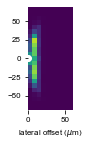

In [87]:
fig,ax = plt.subplots()
p=ax.imshow(neighbors.T/tested.T*Tlx3Kv_ps_array.T,interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0,vmax=0.015,cmap='viridis')
fig.set_figwidth(0.8)
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.yticks(fontname = "arial")
plt.xticks(fontname= "arial")
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
ax.scatter([0],[0],c='white',marker='o')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
print (np.sum(neighbors.T/tested.T*Tlx3Kv_ps_array.T))
#plt.savefig('Tlx3Kv_product_heat.svg')

In [74]:
np.savetxt("Tlx3_prod.csv", neighbors.T/tested.T*Tlx3Kv_ps_array.T, delimiter=",")

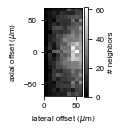

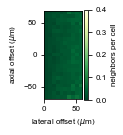

In [75]:
SstKv_neighbors=neighbors_tested(SstKv_inter,z_bins=z_d,xy_bins=x_d)

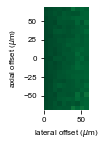

In [76]:
neighbors=SstKv_neighbors['neighbors']
tested=SstKv_neighbors['tested']
xedges=SstKv_neighbors['xedges']
yedges=SstKv_neighbors['yedges']
fig, ax = plt.subplots()
p = ax.imshow(neighbors.T/tested.T, interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0,vmax=0.4,cmap='YlGn_r')
fig.set_figwidth(0.8)
plt.ylabel('axial offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.yticks(fontname = "arial")
plt.xticks(fontname= "arial")
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#plt.savefig('SstKv_normNeigh.svg')

In [77]:
np.savetxt("Sst_neighs.csv", neighbors.T/tested.T, delimiter=",")

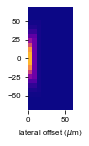

In [78]:
SstKv_ps_array = photostim_heatmap_fit(SstKv_popt_x,SstKv_popt_z,x_d,z_d)
fig, ax = plt.subplots()
p=ax.imshow(SstKv_ps_array.T,interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=1,vmin=0,cmap='plasma')
fig.set_figwidth(0.8)
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
plt.yticks(fontname = "arial")
plt.xticks(fontname= "arial")
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
##plt.savefig('SstKv_ps_sensAdj.svg')

In [79]:
np.savetxt("Sst_photostim.csv", SstKv_ps_array.T, delimiter=",")

0.027499047235153753


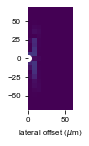

In [80]:
fig,ax = plt.subplots()
p=ax.imshow(neighbors.T/tested.T*SstKv_ps_array.T,interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0,vmax=0.015,cmap='viridis')
fig.set_figwidth(0.8)
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.yticks(fontname = "arial")
plt.xticks(fontname= "arial")
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
ax.scatter([0],[0],c='white',marker='o')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
print (np.sum(neighbors.T/tested.T*SstKv_ps_array.T))
##plt.savefig('SstKv_product_heat.svg')

In [87]:
np.savetxt("Sst_prod.csv", neighbors.T/tested.T*SstKv_ps_array.T, delimiter=",")

In [88]:
def estimate_offtarget_fit(df, x_d, z_d, xy_popt, z_popt, savename=''):
    neighs_dict=neighbors_tested(df,z_bins=z_d,xy_bins=x_d,savename=savename)
    xedges=neighs_dict['xedges']
    yedges=neighs_dict['yedges']
    ps_array=photostim_heatmap_fit(xy_popt,z_popt,x_d,z_d)
    plot_heatmap(ps_array,xedges,yedges,savename)
    neighs_per_cell=neighs_dict['neighbors']/neighs_dict['tested']
    plot_photostim_dens_product(ps_array,neighs_per_cell,xedges,yedges)
    
def plot_heatmap(summary_probs,xedges,yedges,savename=''):
    fig, ax = plt.subplots()
    p=ax.imshow(summary_probs.T, interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=1,vmin=0,cmap='plasma')
    cb=plt.colorbar(p,fraction=0.046*2.2, pad=0.04)
    cb.set_label('off-target spike prob.', fontsize=8, fontname='arial')
    cb.ax.tick_params(labelsize=8) 
    plt.ylabel('axial offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
    plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
    fig.set_figwidth(0.8)
    plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
    plt.yticks(fontname = "arial")
    plt.xticks(fontname= "arial")
    if len(savename)>0:
        plt.savefig(savename+'_psHeat.svg')
    plt.show()
    
    
def plot_photostim_dens_product(summary_probs,neighs_per_cell,xedges,yedges,savename=''):
    p=plt.imshow(neighs_per_cell.T*summary_probs.T,interpolation='nearest',filterrad=1,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0,cmap='plasma')
    plt.scatter([0],[0],s=200,c='white')
    cb=plt.colorbar(p)
    cb.set_label('off-target spike prob. x neighbors/cell', fontsize=10, fontname='arial')
    plt.ylabel('axial offset (' r'$\mu$'+'m)')
    plt.xlabel('lateral offset (' r'$\mu$'+'m)')
    if len(savename)>0:
        plt.savefig(savename+'_prodHeat.svg')
    plt.show()
    print(np.nansum(neighs_per_cell.T*summary_probs.T), "off-target cells/target")

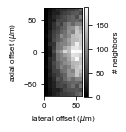

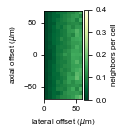

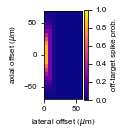

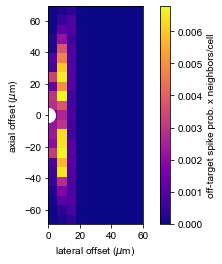

0.12987469691510176 off-target cells/target


In [89]:
##above process is strung together for Cre lines without polished plots. cmap scale will vary across Cre lines.
estimate_offtarget_fit(PenkKv_inter, x_d, z_d, PenkKv_popt_x, PenkKv_popt_z)

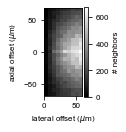

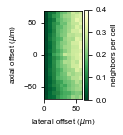

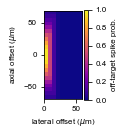

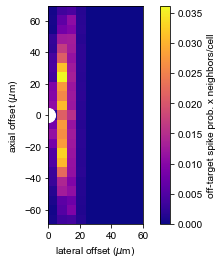

0.8399008301350763 off-target cells/target


In [90]:
estimate_offtarget_fit(RorbKv_inter, x_d, z_d, RorbKv_popt_x, RorbKv_popt_z)

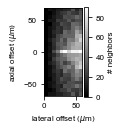

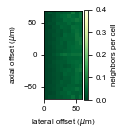

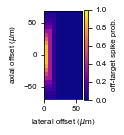

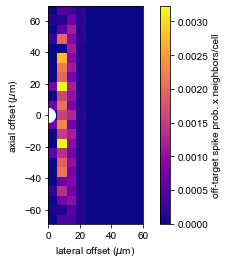

0.060626545658848945 off-target cells/target


In [91]:
estimate_offtarget_fit(RorbAi_inter, x_d, z_d, RorbAi_popt_x, RorbAi_popt_z)

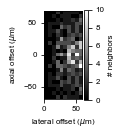

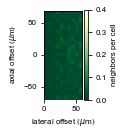

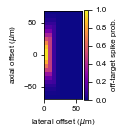

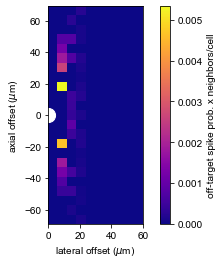

0.028577764783655365 off-target cells/target


In [92]:
estimate_offtarget_fit(Scnn1a_inter, x_d, z_d, Scnn1aAi_popt_x, Scnn1aAi_popt_z)

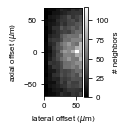

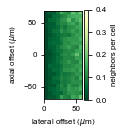

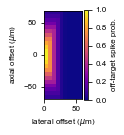

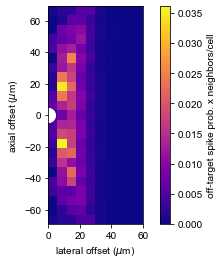

0.9429267516052415 off-target cells/target


In [93]:
estimate_offtarget_fit(Ntsr1_inter, x_d, z_d, Ntsr1Ai_popt_x, Ntsr1Ai_popt_z)

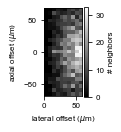

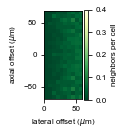

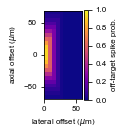

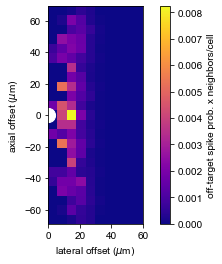

0.12982235881634935 off-target cells/target


In [94]:
estimate_offtarget_fit(PvalbKv_inter, x_d, z_d, PvalbKv_popt_x, PvalbKv_popt_z)

In [96]:
off_ests=pd.read_csv('data/offtarget_ests.csv')
off_ests

,Cre,effector,avg_dens,xy_sig,z_sig,off_est
0,RorbKv,AAV,19813.145110,6.775308,27.635577,0.839901
1,SstKv,AAV,4095.645255,5.042229,15.533890,0.027499
2,Tlx3Kv,AAV,22330.498940,5.332775,15.176749,0.214073
3,PenkKv,AAV,9255.702899,5.444623,21.110383,0.129875
4,PvalbKv,AAV,3349.172504,9.579632,23.224407,0.129822
5,RorbAi,Ai167,4424.813405,6.649579,24.729292,0.060627
6,Ntsr1Ai,Ai167,10094.000590,10.063780,28.370210,0.942927
7,Scnn1aAi,Ai167,1730.001852,6.473506,20.552885,0.028578
8,SstAi,Ai167,1429.936588,6.090537,22.766927,0.012495


In [98]:
##for estimating off-target with homogenous distribution of cells (i.e. # cells proportional to volume)
def neighs_given_dens(density, x_d,z_d):
    i=-1
    z_height=abs(z_d[1]-z_d[0])
    out_array=np.zeros([len(x_d)-1,len(z_d)-1])
    for x in x_d:
        if x!=0:
            sa=math.pi*x**2-math.pi*x_d[i]**2 ##area of outer radius - area of inner radius
            v=sa*z_height/1e9 ##cubic um to cubic mm
            n_cells=v*density
            out_array[i,:]=n_cells
        i+=1
    return out_array     

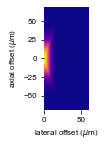

In [99]:
## draw effective point spread functions based on best Cre line/AAV/Ai167 combos
popt=np.array([1,0,5.096]) ##FWHM = 12 um
popt_z=np.array([1,0,14.863]) ##FWHM = 35 um
bs=1
x_d=np.arange(0,61,bs)
z_d=np.arange(-69,70,bs)
ps_sim1=photostim_heatmap_fit(popt,popt_z,x_d,z_d)

fig, ax = plt.subplots()

ax.imshow(ps_sim1.T,extent=[x_d[0], xedges[-1], z_d[0], z_d[-1]],vmax=1,vmin=0,cmap='plasma')

fig.set_figwidth(0.8)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.ylabel('axial offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
#plt.savefig('ps_sim1.svg')
plt.show()

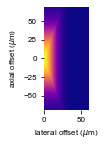

In [100]:
## draw effective point spread functions based on worst Cre line/AAV/Ai167 combos
popt=np.array([1,0,10.192]) #FWHM = 24 um
popt_z=np.array([1,0,28.028]) #FWHM = 66 um 
x_d=np.arange(0,61,bs)
z_d=np.arange(-69,70,bs)

ps_sim2=photostim_heatmap_fit(popt,popt_z,x_d,z_d)

fig, ax = plt.subplots()
p=ax.imshow(ps_sim2.T,extent=[x_d[0], xedges[-1], z_d[0], z_d[-1]],vmax=1,vmin=0,cmap='plasma')
fig.set_figwidth(0.8)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=8, direction='out')
plt.ylabel('axial offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
plt.xlabel('lateral offset (' r'$\mu$'+'m)',fontsize=8,fontname='arial')
#plt.savefig('ps_sim2.svg')
plt.show()

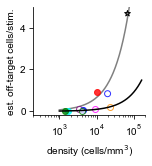

In [101]:
csv_file=open('homogenous_dist_offT.csv','w')

d_list=np.arange(1000,164000,1000) ##range of cell densities
off_ts=[]
fig, ax = plt.subplots()
for density in d_list:
    out=neighs_given_dens(density,x_d,z_d)
    prod=ps_sim1*out
    off_ts.append(np.sum(prod))
ax.plot(d_list,off_ts,c='black')
opto.write_csv(csv_file,d_list,'densities(cell/mm3)')
opto.write_csv(csv_file,off_ts,'high_res_offT')

off_ts=[]
for density in d_list:
    out=neighs_given_dens(density,x_d,z_d)
    prod=ps_sim2*out
    off_ts.append(np.sum(prod))
ax.plot(d_list,off_ts,c='grey',zorder=0)
opto.write_csv(csv_file,off_ts,'low_res_offT')

colors=['blue','green','darkorange','magenta','purple','blue','red','cyan','green']
facecolors=['none','white','white','white','white','blue','red','cyan','green']
zs=[1,2,1,1,1,1,1,1,1]
for i in off_ests.index:
    c=colors[i]
    f=facecolors[i]
    z=zs[i]
    avg_d=off_ests.avg_dens[i]
    off=off_ests.off_est[i]
    ax.scatter(avg_d, off,edgecolors=c,facecolors=f,zorder=z,alpha=0.8)

ax.scatter([68000],[4.7],facecolor='grey', marker='*', edgecolor='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xscale('log')
#plt.yscale('log')
plt.axis([200,200000,-0.2,5])
plt.ylabel('est. off-target cells/stim.')
plt.xlabel('density (cells/mm$^{3}$)')
fig.set_figheight(2)
fig.set_figwidth(2)  
csv_file.close()
#plt.savefig('off_target_v_density.svg')

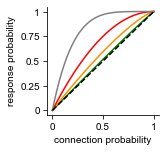

In [102]:
csv_file=open('Presponse_v_Pcnx.csv','w')
ns=[1.05,1.3,2,5]
cs=['green','darkorange','red','grey']
Pcnx=np.arange(0,1.01,0.01)
opto.write_csv(csv_file,Pcnx,'connection probability')
fig, ax = plt.subplots()

for n, c in zip(ns,cs):
    
    Pnocnx=(1-Pcnx)**n
    Patleast1=1-Pnocnx
    ax.plot(Pcnx,Patleast1,c=c)
    description="n="+str(n)
    opto.write_csv(csv_file, Patleast1, "response prob "+description)
ax.plot([0,1],[0,1],c='black',ls='dashed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.ylabel('response probability')
plt.xlabel('connection probability')
fig.set_figheight(2)
fig.set_figwidth(2)    
plt.savefig('rf_vs_PCnx.svg')
csv_file.close()

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/644726190.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/644726190.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/644726190.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/644726190.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1


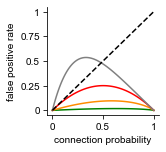

In [103]:
fig, ax = plt.subplots()
for n, c in zip(ns,cs):
    
    Pnocnx=(1-Pcnx)**n
    Patleast1=1-Pnocnx
    PoffCnx=1-(1-Pcnx)**(n-1)
    Pfp=(1-Pcnx)*PoffCnx
    ppv=Pcnx/Patleast1
    ax.plot(Pcnx,Pfp,c=c)
ax.plot([0,1],[0,1],c='black',ls='dashed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.ylabel('false positive rate')
plt.xlabel('connection probability')
fig.set_figheight(2)
fig.set_figwidth(2)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2461507170.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2461507170.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2461507170.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_16502/2461507170.py:8: RuntimeWarning: invalid value encountered in true_divide
  ppv=Pcnx/Patleast1


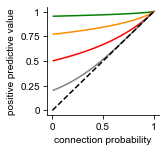

In [104]:
fig, ax = plt.subplots()
for n, c in zip(ns,cs):
    
    Pnocnx=(1-Pcnx)**n
    Patleast1=1-Pnocnx
    PoffCnx=1-(1-Pcnx)**(n-1)
    Pfp=(1-Pcnx)*PoffCnx
    ppv=Pcnx/Patleast1
    ax.plot(Pcnx,ppv,c=c)
ax.plot([0,1],[0,1],c='black',ls='dashed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.ylabel('positive predictive value')
plt.xlabel('connection probability')
fig.set_figheight(2)
fig.set_figwidth(2)

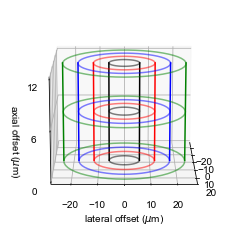

In [105]:


def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

center_x, center_y = 0, 0
r_step=6
h=12

rs=25

Xc,Yc,Zc = data_for_cylinder_along_z(center_x,center_y,r_step*1,h)
ax.plot_wireframe(Xc, Yc, Zc, alpha=0.5,color='black',rstride=rs, cstride=0)
ax.plot([0,0],[r_step*1,r_step*1],[0,h],c='black')
ax.plot([0,0],[r_step*-1,r_step*-1],[0,h],c='black')
Xc,Yc,Zc = data_for_cylinder_along_z(center_x,center_y,r_step*2,h)
ax.plot_wireframe(Xc, Yc, Zc, alpha=0.5,color='red',rstride=rs, cstride=0)
ax.plot([0,0],[r_step*2,r_step*2],[0,h],c='red')
ax.plot([0,0],[r_step*-2,r_step*-2],[0,h],c='red')

Xc,Yc,Zc = data_for_cylinder_along_z(center_x,center_y,r_step*3,h)
ax.plot_wireframe(Xc, Yc, Zc, alpha=0.5,color='blue',rstride=rs, cstride=0)
ax.plot([0,0],[r_step*3,r_step*3],[0,h],c='blue')
ax.plot([0,0],[r_step*-3,r_step*-3],[0,h],c='blue')

Xc,Yc,Zc = data_for_cylinder_along_z(center_x,center_y,r_step*4,h)
ax.plot_wireframe(Xc, Yc, Zc, alpha=0.5,color='green',rstride=rs, cstride=0)
ax.plot([0,0],[r_step*4,r_step*4],[0,h],c='green')
ax.plot([0,0],[r_step*-4,r_step*-4],[0,h],c='green')

ax.set_ylabel('lateral offset (' r'$\mu$'+'m)',fontsize=10,fontname='arial')
ax.set_zlabel('axial offset (' r'$\mu$'+'m)',fontsize=10,fontname='arial')
ax.set_zticks([0,h/2,h])


ax.view_init(15,0)

plt.show()


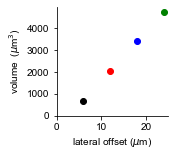

In [106]:
n=4
colors=['black', 'red', 'blue', 'green']
fig, ax = plt.subplots()
for i in range(n):
    c=colors[i]
    inner=r_step*i
    outer=r_step*(i+1)
    sa=math.pi*outer**2-math.pi*inner**2
    v=sa*r_step 
    plt.scatter(outer,v,c=c)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_lim=ax.get_xlim()
y_lim=ax.get_ylim()
ax.set_xlim([0,x_lim[1]])
ax.set_ylim([0,y_lim[1]])
ax.set_xlabel('lateral offset (' r'$\mu$'+'m)', fontsize=10, fontname='arial')
ax.set_ylabel('volume  (' r'$\mu$'+'m'+'$^{3}$)', fontsize=10, fontname='arial')
ax.tick_params(axis='both', which='both', labelsize=10, direction='out')
fig.set_figwidth(2)
fig.set_figheight(2)
#plt.savefig('volume_vs_lateral_r.svg')
plt.show()